# BatchNorm intuitions

In [1]:
%matplotlib inline
# %matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.utils.data as Data
import torch.nn.functional as F

torch.manual_seed(42)
np.random.seed(42)

## 1. Impact on activations and results

Practical inspired from [Morvan Zhou](https://github.com/MorvanZhou/PyTorch-Tutorial)





In [28]:
class ExperimentParams():
    def __init__(self):
        self.num_samples = 2000
        self.batch_size = 64
        self.lr = 3e-2
        self.n_hidden = 8
        self.num_epochs = 12
        self.num_workers = 4
                
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.data_dir = '/home/docker_user/'
        

args = ExperimentParams()

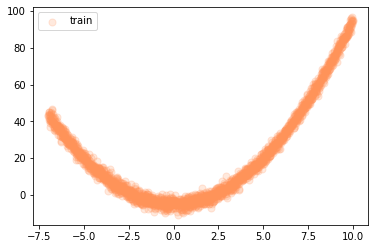

In [29]:
# training data
x = np.linspace(-7, 10, args.num_samples)[:, np.newaxis]
noise = np.random.normal(0, 2, x.shape)
y = np.square(x) - 5 + noise

# test data
test_x = np.linspace(-7, 10, 200)[:, np.newaxis]
noise = np.random.normal(0, 2, test_x.shape)
test_y = np.square(test_x) - 5 + noise

train_x, train_y = torch.from_numpy(x).float(), torch.from_numpy(y).float()
test_x, test_y = torch.from_numpy(test_x).float(), torch.from_numpy(test_y).float()

train_dataset = Data.TensorDataset(train_x, train_y)
train_loader = Data.DataLoader(dataset=train_dataset, batch_size=args.batch_size, shuffle=True, num_workers=2,)

# show data
plt.scatter(train_x.numpy(), train_y.numpy(), c='#FF9359', s=50, alpha=0.2, label='train')
plt.legend(loc='upper left')

In [40]:
class Net(nn.Module):
    def __init__(self, n_hidden,batch_normalization=False, bias_init= -0.2):
        super(Net, self).__init__()
        self.n_hidden = n_hidden
        self.do_bn = batch_normalization
        self.fcs = []
        self.bns = []
        self.bn_input = nn.BatchNorm1d(1, momentum=0.5)  
        self.activation = nn.Tanh()
        self.bias_init = bias_init 
        
        for i in range(self.n_hidden):               # build hidden layers and BN layers
            input_size = 1 if i == 0 else 10
            fc = nn.Linear(input_size, 10)
            setattr(self, 'fc%i' % i, fc)       # IMPORTANT set layer to the Module
            self._set_init(fc)                  # parameters initialization
            self.fcs.append(fc)
            if self.do_bn:
                bn = nn.BatchNorm1d(10, momentum=0.5)
                setattr(self, 'bn%i' % i, bn)   # IMPORTANT set layer to the Module
                self.bns.append(bn)

        self.predict = nn.Linear(10, 1)         # output layer
        self._set_init(self.predict)            # parameters initialization

    def _set_init(self, layer):
        nn.init.normal_(layer.weight, mean=0., std=.1)
        nn.init.constant_(layer.bias, self.bias_init)

    def forward(self, x):
        pre_activation = [x]
        if self.do_bn: 
            x = self.bn_input(x)     # input batch normalization
        
        layer_input = [x]
        for i in range(self.n_hidden):
            x = self.fcs[i](x)
            pre_activation.append(x)
            if self.do_bn: 
                x = self.bns[i](x)   # batch normalization
            x = self.activation(x)
            layer_input.append(x)
        
        out = self.predict(x)
        return out, layer_input, pre_activation

In [31]:
nets = [Net(n_hidden=args.n_hidden, batch_normalization=False), Net(n_hidden=args.n_hidden, batch_normalization=True)]

print(*nets)    # print net architecture

Net(
  (bn_input): BatchNorm1d(1, eps=1e-05, momentum=0.5, affine=True, track_running_stats=True)
  (activation): Tanh()
  (fc0): Linear(in_features=1, out_features=10, bias=True)
  (fc1): Linear(in_features=10, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=10, bias=True)
  (fc4): Linear(in_features=10, out_features=10, bias=True)
  (fc5): Linear(in_features=10, out_features=10, bias=True)
  (fc6): Linear(in_features=10, out_features=10, bias=True)
  (fc7): Linear(in_features=10, out_features=10, bias=True)
  (predict): Linear(in_features=10, out_features=1, bias=True)
) Net(
  (bn_input): BatchNorm1d(1, eps=1e-05, momentum=0.5, affine=True, track_running_stats=True)
  (activation): Tanh()
  (fc0): Linear(in_features=1, out_features=10, bias=True)
  (bn0): BatchNorm1d(10, eps=1e-05, momentum=0.5, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=10, out_features=10, bias=True)
  (bn1

In [32]:
optimizers = [torch.optim.Adam(net.parameters(), lr=args.lr) for net in nets]

loss_fn = torch.nn.MSELoss()

In [33]:
def plot_histogram(l_in, l_in_bn, pre_ac, pre_ac_bn):
    for i, (ax_pa, ax_pa_bn, ax,  ax_bn) in enumerate(zip(axs[0, :], axs[1, :], axs[2, :], axs[3, :])):
        [a.clear() for a in [ax_pa, ax_pa_bn, ax, ax_bn]]
        if i == 0: 
            p_range = (-7, 10)
            the_range = (-7, 10)
        else:
            p_range = (-4, 4)
            the_range = (-1, 1)
            
        ax_pa.set_title('L' + str(i))
        ax_pa.hist(pre_ac[i].data.numpy().ravel(), bins=10, range=p_range, color='orange', alpha=0.5);
        ax_pa_bn.hist(pre_ac_bn[i].data.numpy().ravel(), bins=10, range=p_range, color='green', alpha=0.5)
        ax.hist(l_in[i].data.numpy().ravel(), bins=10, range=the_range, color='orange');
        ax_bn.hist(l_in_bn[i].data.numpy().ravel(), bins=10, range=the_range, color='green')
        
        for a in [ax_pa, ax, ax_pa_bn, ax_bn]: 
            a.set_yticks(())
            a.set_xticks(())
       
        ax_pa_bn.set_xticks(p_range)
        ax_bn.set_xticks(the_range)
        axs[0, 0].set_ylabel('PreAct');
        axs[1, 0].set_ylabel('BN PreAct');
        axs[2, 0].set_ylabel('Act');
        axs[3, 0].set_ylabel('BN Act')
    plt.pause(0.01)

Epoch:  0


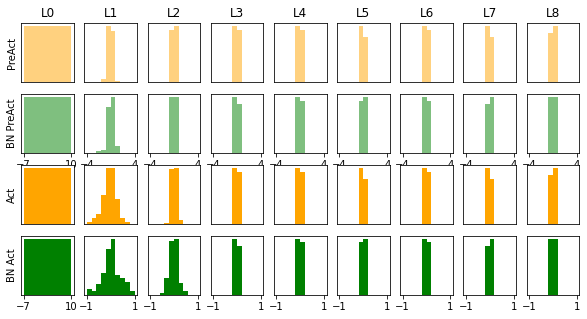

Epoch:  1


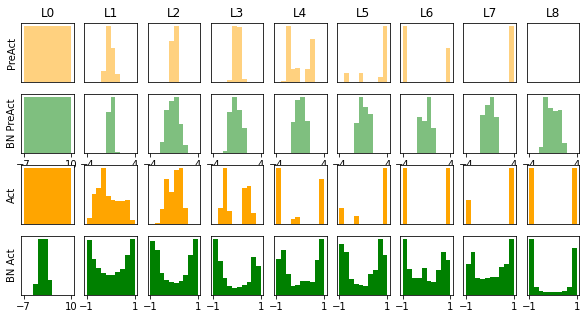

Epoch:  2


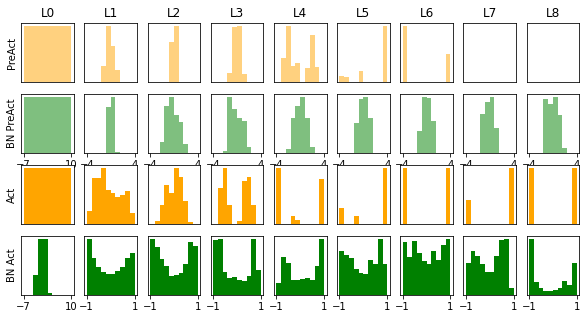

Epoch:  3


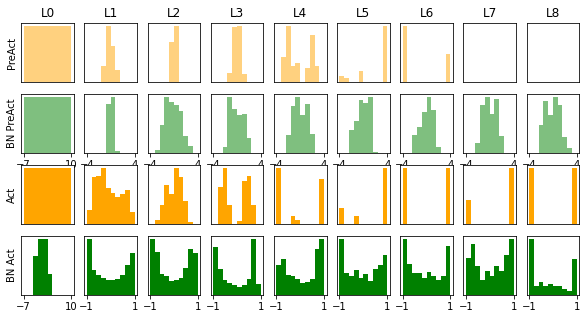

Epoch:  4


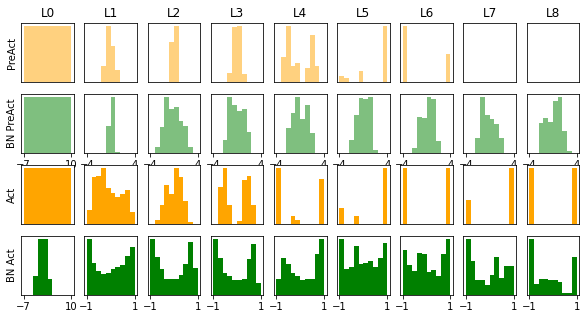

Epoch:  5


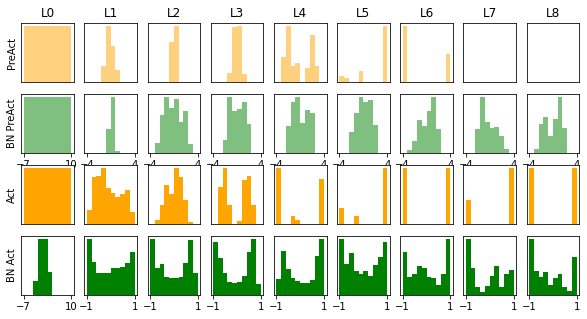

Epoch:  6


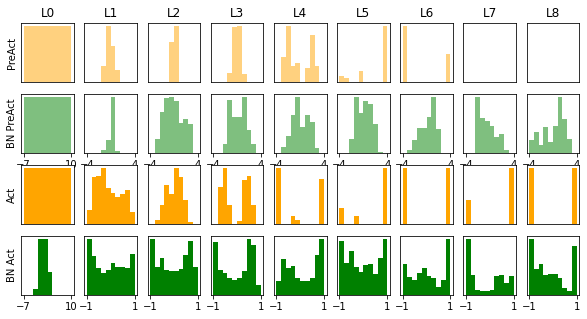

Epoch:  7


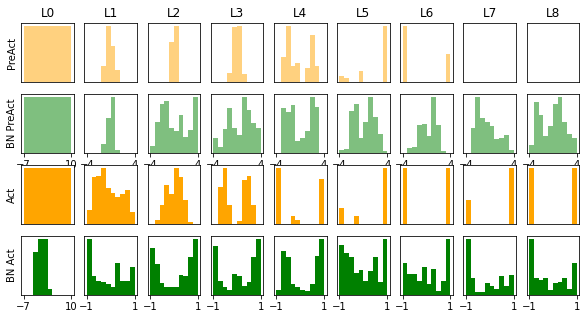

Epoch:  8


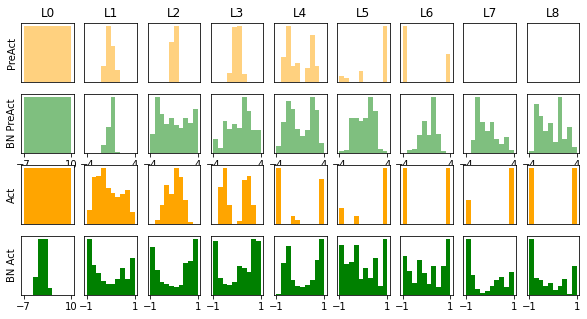

Epoch:  9


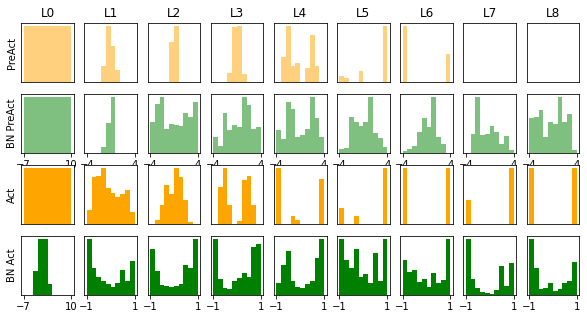

Epoch:  10


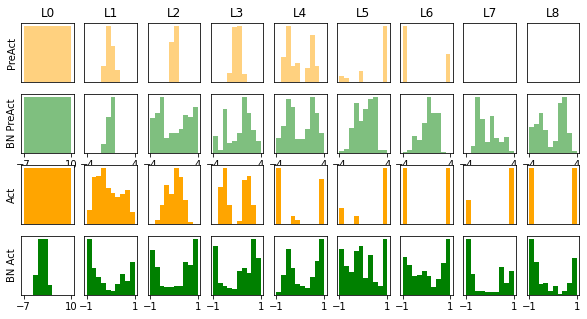

Epoch:  11


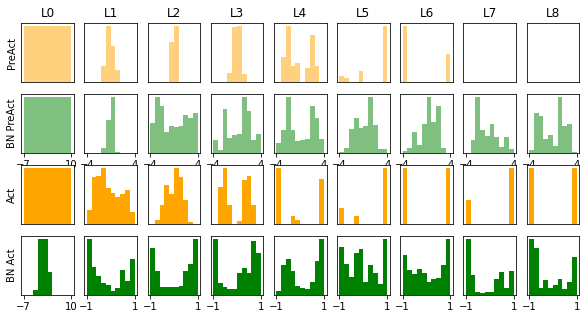

In [34]:
# training
losses = [[], []]  # record loss for two networks
for epoch in range(args.num_epochs):
    print('Epoch: ', epoch)
    layer_inputs, pre_acts = [], []
    for net, l in zip(nets, losses):
        net.eval()              # set eval mode to fix moving_mean and moving_var
        pred, layer_input, pre_act = net(test_x)
        l.append(loss_fn(pred, test_y).item())
        layer_inputs.append(layer_input)
        pre_acts.append(pre_act)
        net.train()             # free moving_mean and moving_var

        
    f, axs = plt.subplots(4, args.n_hidden+1, figsize=(10, 5))
    plot_histogram(*layer_inputs, *pre_acts)     # plot histogram

    for step, (b_x, b_y) in enumerate(train_loader):
        for net, opt in zip(nets, optimizers):     # train for each network
            pred, _, _ = net(b_x)
            loss = loss_fn(pred, b_y)
            opt.zero_grad()
            loss.backward()
            opt.step()    # it will also learns the parameters in Batch Normalization
            

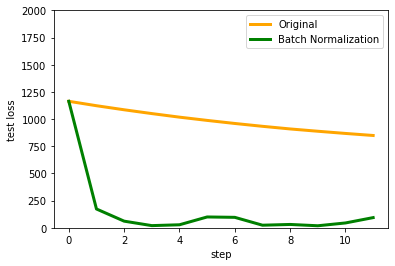

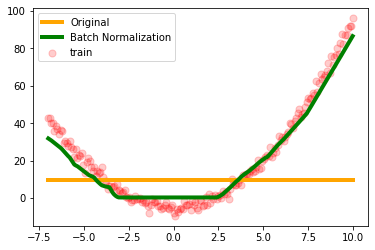

In [16]:
# plot training loss
plt.figure(2)
plt.plot(losses[0], c='orange', lw=3, label='Original')
plt.plot(losses[1], c='green', lw=3, label='Batch Normalization')
plt.xlabel('step');
plt.ylabel('test loss');
plt.ylim((0, 2000));
plt.legend(loc='best')

# evaluation
# set net to eval mode to freeze the parameters in batch normalization layers
[net.eval() for net in nets]    # set eval mode to fix moving_mean and moving_var
preds = [net(test_x)[0] for net in nets]
plt.figure(3)
plt.plot(test_x.data.numpy(), preds[0].data.numpy(), c='orange', lw=4, label='Original')
plt.plot(test_x.data.numpy(), preds[1].data.numpy(), c='green', lw=4, label='Batch Normalization')
plt.scatter(test_x.data.numpy(), test_y.data.numpy(), c='r', s=50, alpha=0.2, label='train')
plt.legend(loc='best')
plt.show()

## 2. Dependency on weight initialization

Practical inspired from [Francois Fleuret](https://fleuret.org/dlc/)

We will generate a toy dataset using `scikit-learn`

In [17]:
from sklearn import datasets

In [35]:
x, y = datasets.make_circles(n_samples=args.num_samples, factor=.5, noise=.05)
train_x, train_y = torch.from_numpy(x).float(), torch.from_numpy(y).long()

# test data
test_x, test_y = datasets.make_circles(n_samples=200, factor=.5, noise=.05)
test_x, test_y = torch.from_numpy(test_x).float(), torch.from_numpy(test_y).long()


train_dataset = Data.TensorDataset(train_x, train_y)
train_loader = Data.DataLoader(dataset=train_dataset, batch_size=args.batch_size, shuffle=True, num_workers=2,)



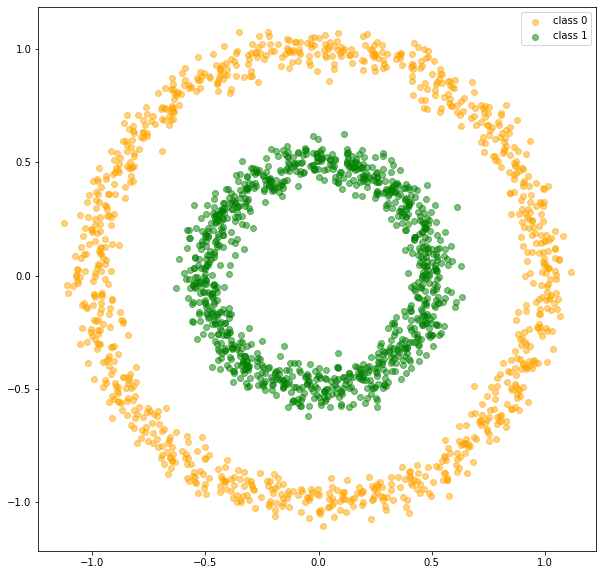

In [36]:

plt.figure(figsize=(10,10))
colors = ['orange', 'green']
for i in range(2):
    inds = np.where(y==i)[0]
    plt.scatter(x[inds,0], x[inds,1], alpha=0.5, color=colors[i])

plt.legend(['class 0', 'class 1'])


This is a script for creating a model on the fly

In [37]:
def create_model(with_batchnorm, nc = 32, depth = 16):
    modules = []
    modules.append(nn.Linear(2, nc))
    if with_batchnorm: 
        modules.append(nn.BatchNorm1d(nc))
    
    modules.append(nn.ReLU())
    for d in range(depth):
        modules.append(nn.Linear(nc, nc))
        if with_batchnorm: 
            modules.append(nn.BatchNorm1d(nc))
        modules.append(nn.ReLU())
    
    modules.append(nn.Linear(nc, 2))
    
    return nn.Sequential(*modules)

In [38]:
stds = [1e-3, 1e-2, 1e-1, 1e0, 1e1]
args.num_epochs = 10

accuracies = [[], []]
losses = [[], []]  # record test loss for two networks
for std in stds:
    print(f'Initializing nets with std: {std}')
    nets = [create_model(with_batchnorm=False), create_model(with_batchnorm=True)]
    
    optimizers = [torch.optim.Adam(net.parameters(), lr=args.lr) for net in nets]

    loss_fn = torch.nn.CrossEntropyLoss()
    for net in nets:
        with torch.no_grad():
            for p in net.parameters(): p.normal_(0, std)

    net.train()
    for epoch in range(args.num_epochs):
        for step, (b_x, b_y) in enumerate(train_loader):
            for net, opt in zip(nets, optimizers):     # train for each network
                output = net(b_x)
                loss = loss_fn(output, b_y)
                opt.zero_grad()
                loss.backward()
                opt.step()    # it will also learns the parameters in Batch Normalization

    for net, l, acc in zip(nets, losses, accuracies):
        net.eval()
        output = net(test_x)
        l.append(loss_fn(output, test_y).item())
        _,pred = torch.max(output.data,1)
        corrects = torch.sum(pred == test_y).float()/test_y.numel()
        acc.append(corrects.item())


Initializing nets with std: 0.001
Initializing nets with std: 0.01
Initializing nets with std: 0.1
Initializing nets with std: 1.0
Initializing nets with std: 10.0


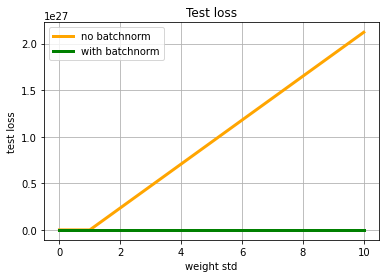

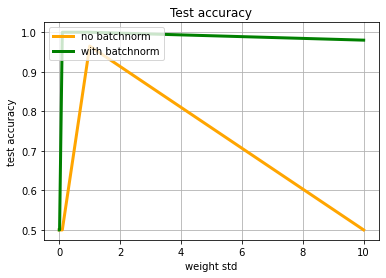

In [39]:
# plotting
plt.cla()
plt.plot(stds, losses[0], 'orange', lw=3, label='no batchnorm')
plt.plot(stds, losses[1], 'green', lw=3, label='with batchnorm')
plt.legend(loc='upper left'); 
plt.xlabel('weight std')
plt.ylabel('test loss')
plt.title('Test loss')
plt.grid(True)
plt.pause(0.1)

plt.show()
        
plt.cla()
plt.plot(stds, accuracies[0], 'orange', lw=3, label='no batchnorm')
plt.plot(stds, accuracies[1], 'green', lw=3, label='with batchnorm')
plt.legend(loc='upper left'); 
plt.xlabel('weight std')
plt.ylabel('test accuracy')
plt.title('Test accuracy')
plt.grid(True)
plt.pause(0.1)
plt.show()
        

# 3. Exercises

1. Code a similar pipeline from Dropout, with conv layers, comparing variant with and without BatchNorm. What do you notice?
2. Try out larger learning rate values. Plot the decrease in training and test error.
3. Do we need Batch Normalization in every layer? Experiment with it?